# Homework:
# Deep Convolutional Generative Adversarial Network 

Description of an implementation of DCGAN can be found in [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](https://arxiv.org/abs/1511.06434).

In [1]:
#Import the libraries we will need.
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import os
import scipy.misc
import scipy

We will be using the MNIST dataset. input_data is a library that downloads the dataset and uzips it automatically.

In [2]:
mnist = input_data.read_data_sets('fashion/data', one_hot=False)

Extracting fashion/data/train-images-idx3-ubyte.gz
Extracting fashion/data/train-labels-idx1-ubyte.gz
Extracting fashion/data/t10k-images-idx3-ubyte.gz
Extracting fashion/data/t10k-labels-idx1-ubyte.gz


### Helper Functions

In [3]:
#This function performns a leaky relu activation, which is needed for the discriminator network.
def lrelu(x, leak=0.2, name="lrelu"):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)
    
#The below functions are taken from carpdem20's implementation https://github.com/carpedm20/DCGAN-tensorflow
#They allow for saving sample images from the generator to follow progress
def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def imsave(images, size, path):
    return scipy.misc.imsave(path, merge(images, size))

def inverse_transform(images):
    return (images+1.)/2.

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image

    return img

## Defining the Adversarial Networks

### Generator Network

In [4]:
def generator(z):
    
    zP = slim.fully_connected(z,4*4*256,normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_project',weights_initializer=initializer)
    zCon = tf.reshape(zP,[-1,4,4,256])
    
    gen1 = slim.convolution2d_transpose(\
        zCon,num_outputs=64,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv1', weights_initializer=initializer)
    
    gen2 = slim.convolution2d_transpose(\
        gen1,num_outputs=32,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv2', weights_initializer=initializer)
    
    gen3 = slim.convolution2d_transpose(\
        gen2,num_outputs=16,kernel_size=[5,5],stride=[2,2],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv3', weights_initializer=initializer)
    
    g_out = slim.convolution2d_transpose(\
        gen3,num_outputs=1,kernel_size=[32,32],padding="SAME",\
        biases_initializer=None,activation_fn=tf.nn.tanh,\
        scope='g_out', weights_initializer=initializer)
    
    return g_out

### Discriminator Network

### Task1 (13 points)
Fill parameter for the discrimiator architecture

In [5]:
def discriminator(bottom, reuse=False):
    with slim.arg_scope([slim.fully_connected, slim.convolution2d], reuse=reuse, weights_initializer=initializer):
        # Your code here
        dis1 = slim.convolution2d(bottom, scope='d_conv1', num_outputs=16, kernel_size=[32,32], 
                                  padding="SAME",normalizer_fn=slim.batch_norm, activation_fn=lrelu,
                                  weights_initializer=initializer)

        dis2 = slim.convolution2d(dis1, scope='d_conv2', num_outputs=32, kernel_size=[5,5],stride=[2,2], 
                                  padding="SAME",normalizer_fn=slim.batch_norm, activation_fn=lrelu,
                                  weights_initializer=initializer)

        dis3 = slim.convolution2d(dis2,scope='d_conv3', num_outputs=64, kernel_size=[5,5],stride=[2,2], 
                                  padding="SAME",normalizer_fn=slim.batch_norm, activation_fn=lrelu,
                                  weights_initializer=initializer)

        dis4 = slim.convolution2d(dis3, scope='d_conv4', num_outputs=128, kernel_size=[5, 5], stride=[2, 2],
                                 padding="SAME",normalizer_fn=slim.batch_norm, activation_fn=lrelu,
                                 weights_initializer=initializer)
        
        d_out = slim.fully_connected(slim.flatten(dis4), scope='d_out', num_outputs=1, 
                                     activation_fn=tf.nn.sigmoid,weights_initializer=initializer)
    
    return d_out

### Connecting them together

In [6]:
tf.reset_default_graph()

z_size = 100 #Size of z vector used for generator.

#This initializaer is used to initialize all the weights of the network.
initializer = tf.truncated_normal_initializer(stddev=0.02)

#These two placeholders are used for input into the generator and discriminator, respectively.
z_in = tf.placeholder(shape=[None,z_size],dtype=tf.float32) #Random vector
real_in = tf.placeholder(shape=[None,32,32,1],dtype=tf.float32) #Real images

Gz = generator(z_in) #Generates images from random z vectors
Dx = discriminator(real_in) #Produces probabilities for real images
Dg = discriminator(Gz,reuse=True) #Produces probabilities for generator images

#These functions together define the optimization objective of the GAN.
d_loss = -tf.reduce_mean(tf.log(Dx) + tf.log(1.-Dg)) #This optimizes the discriminator.
g_loss = -tf.reduce_mean(tf.log(Dg)) #This optimizes the generator.

tvars = tf.trainable_variables()

#The below code is responsible for applying gradient descent to update the GAN.
trainerD = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
trainerG = tf.train.AdamOptimizer(learning_rate=0.0002,beta1=0.5)
d_grads = trainerD.compute_gradients(d_loss,tvars[9:]) #Only update the weights for the discriminator network.
g_grads = trainerG.compute_gradients(g_loss,tvars[0:9]) #Only update the weights for the generator network.

update_D = trainerD.apply_gradients(d_grads)
update_G = trainerG.apply_gradients(g_grads)

## Training the network
I strongly advise you to skip this cell and go the the next one since training will take you enormous amount of time

In [9]:
batch_size = 128 #Size of image batch to apply at each iteration.
iterations = 20000 #Total number of iterations to use.
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to save trained model to.

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    for i in range(iterations):
        zs = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate a random z batch
        xs,_ = mnist.train.next_batch(batch_size) #Draw a sample batch from MNIST dataset.
        xs = (np.reshape(xs,[batch_size,28,28,1]) - 0.5) * 2.0 #Transform it to be between -1 and 1
        xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1)) #Pad the images so the are 32x32
        _,dLoss = sess.run([update_D,d_loss],feed_dict={z_in:zs,real_in:xs}) #Update the discriminator
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs}) #Update the generator, twice for good measure.
        _,gLoss = sess.run([update_G,g_loss],feed_dict={z_in:zs})
        if i % 10 == 0:
            print(i)
            print("Gen Loss: " + str(gLoss) + " Disc Loss: " + str(dLoss))
            z2 = np.random.uniform(-1.0,1.0,size=[batch_size,z_size]).astype(np.float32) #Generate another z batch
            newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
            if not os.path.exists(sample_directory):
                os.makedirs(sample_directory)
            #Save sample generator images for viewing training progress.
            save_images(np.reshape(newZ[0:36],[36,32,32]),[6,6],sample_directory+'/fig'+str(i)+'.png')
        if i % 10 == 0 and i != 0:
            if not os.path.exists(model_directory):
                os.makedirs(model_directory)
            saver.save(sess,model_directory+'/model-'+str(i)+'.cptk')
            print("Saved Model")

0
Gen Loss: 0.404194 Disc Loss: 1.53684
10
Gen Loss: 0.514555 Disc Loss: 2.23798
Saved Model
20
Gen Loss: 1.44162 Disc Loss: 1.65029
Saved Model
30
Gen Loss: 1.57922 Disc Loss: 1.44692
Saved Model
40
Gen Loss: 1.58983 Disc Loss: 0.616721
Saved Model
50
Gen Loss: 1.79258 Disc Loss: 1.44954
Saved Model
60
Gen Loss: 1.77255 Disc Loss: 0.54735
Saved Model
70
Gen Loss: 1.01564 Disc Loss: 1.10452
Saved Model
80
Gen Loss: 0.98222 Disc Loss: 1.41146
Saved Model
90
Gen Loss: 0.799843 Disc Loss: 1.42232
Saved Model
100
Gen Loss: 0.892945 Disc Loss: 1.33925
Saved Model
110
Gen Loss: 0.884287 Disc Loss: 1.35031
Saved Model
120
Gen Loss: 1.13012 Disc Loss: 1.05664
Saved Model
130
Gen Loss: 0.880977 Disc Loss: 1.26156
Saved Model
140
Gen Loss: 0.8579 Disc Loss: 1.45836
Saved Model
150
Gen Loss: 0.899095 Disc Loss: 1.37962
Saved Model
160
Gen Loss: 0.820946 Disc Loss: 1.33801
Saved Model
170
Gen Loss: 0.875299 Disc Loss: 1.34822
Saved Model
180
Gen Loss: 0.861817 Disc Loss: 1.32447
Saved Model
190
Ge

Saved Model
1520
Gen Loss: 0.824599 Disc Loss: 1.37204
Saved Model
1530
Gen Loss: 0.750268 Disc Loss: 1.3652
Saved Model
1540
Gen Loss: 0.733321 Disc Loss: 1.39888
Saved Model
1550
Gen Loss: 0.75076 Disc Loss: 1.35036
Saved Model
1560
Gen Loss: 0.695451 Disc Loss: 1.39759
Saved Model
1570
Gen Loss: 0.697886 Disc Loss: 1.39456
Saved Model
1580
Gen Loss: 0.850987 Disc Loss: 1.37084
Saved Model
1590
Gen Loss: 0.818004 Disc Loss: 1.29219
Saved Model
1600
Gen Loss: 0.733518 Disc Loss: 1.33533
Saved Model
1610
Gen Loss: 0.777938 Disc Loss: 1.38988
Saved Model
1620
Gen Loss: 0.78608 Disc Loss: 1.32877
Saved Model
1630
Gen Loss: 0.756622 Disc Loss: 1.37676
Saved Model
1640
Gen Loss: 0.704863 Disc Loss: 1.34872
Saved Model
1650
Gen Loss: 0.735161 Disc Loss: 1.37188
Saved Model
1660
Gen Loss: 0.757758 Disc Loss: 1.36321
Saved Model
1670
Gen Loss: 0.747309 Disc Loss: 1.41023
Saved Model
1680
Gen Loss: 0.778507 Disc Loss: 1.32318
Saved Model
1690
Gen Loss: 0.76775 Disc Loss: 1.35712
Saved Model
17

Saved Model
3020
Gen Loss: 0.721823 Disc Loss: 1.38114
Saved Model
3030
Gen Loss: 0.647156 Disc Loss: 1.39345
Saved Model
3040
Gen Loss: 0.825266 Disc Loss: 1.37734
Saved Model
3050
Gen Loss: 0.755379 Disc Loss: 1.37227
Saved Model
3060
Gen Loss: 0.817793 Disc Loss: 1.34247
Saved Model
3070
Gen Loss: 0.818734 Disc Loss: 1.39174
Saved Model
3080
Gen Loss: 0.751988 Disc Loss: 1.3375
Saved Model
3090
Gen Loss: 0.688639 Disc Loss: 1.4209
Saved Model
3100
Gen Loss: 0.740685 Disc Loss: 1.32758
Saved Model
3110
Gen Loss: 0.780257 Disc Loss: 1.35047
Saved Model
3120
Gen Loss: 0.726145 Disc Loss: 1.35099
Saved Model
3130
Gen Loss: 0.741091 Disc Loss: 1.36903
Saved Model
3140
Gen Loss: 0.776579 Disc Loss: 1.33089
Saved Model
3150
Gen Loss: 0.733725 Disc Loss: 1.39599
Saved Model
3160
Gen Loss: 0.695769 Disc Loss: 1.3833
Saved Model
3170
Gen Loss: 0.705054 Disc Loss: 1.39136
Saved Model
3180
Gen Loss: 0.758123 Disc Loss: 1.32131
Saved Model
3190
Gen Loss: 0.695481 Disc Loss: 1.3706
Saved Model
32

Saved Model
4520
Gen Loss: 0.756854 Disc Loss: 1.33739
Saved Model
4530
Gen Loss: 0.679677 Disc Loss: 1.38775
Saved Model
4540
Gen Loss: 0.72134 Disc Loss: 1.35219
Saved Model
4550
Gen Loss: 0.784271 Disc Loss: 1.35151
Saved Model
4560
Gen Loss: 0.749788 Disc Loss: 1.33748
Saved Model
4570
Gen Loss: 0.767766 Disc Loss: 1.31112
Saved Model
4580
Gen Loss: 0.721421 Disc Loss: 1.32791
Saved Model
4590
Gen Loss: 0.719392 Disc Loss: 1.37387
Saved Model
4600
Gen Loss: 0.717746 Disc Loss: 1.35094
Saved Model
4610
Gen Loss: 0.782126 Disc Loss: 1.32526
Saved Model
4620
Gen Loss: 0.730813 Disc Loss: 1.31917
Saved Model
4630
Gen Loss: 0.777833 Disc Loss: 1.35613
Saved Model
4640
Gen Loss: 0.769429 Disc Loss: 1.30703
Saved Model
4650
Gen Loss: 0.710498 Disc Loss: 1.36479
Saved Model
4660
Gen Loss: 0.716985 Disc Loss: 1.37726
Saved Model
4670
Gen Loss: 0.760384 Disc Loss: 1.32045
Saved Model
4680
Gen Loss: 0.70633 Disc Loss: 1.37532
Saved Model
4690
Gen Loss: 0.754908 Disc Loss: 1.39076
Saved Model


Saved Model
6020
Gen Loss: 0.731792 Disc Loss: 1.30766
Saved Model
6030
Gen Loss: 0.718005 Disc Loss: 1.31224
Saved Model
6040
Gen Loss: 0.735768 Disc Loss: 1.39252
Saved Model
6050
Gen Loss: 0.699177 Disc Loss: 1.35291
Saved Model
6060
Gen Loss: 0.821656 Disc Loss: 1.32372
Saved Model
6070
Gen Loss: 0.749167 Disc Loss: 1.39815
Saved Model
6080
Gen Loss: 0.678285 Disc Loss: 1.32084
Saved Model
6090
Gen Loss: 0.660346 Disc Loss: 1.37908
Saved Model
6100
Gen Loss: 0.709471 Disc Loss: 1.37475
Saved Model
6110
Gen Loss: 0.718693 Disc Loss: 1.34508
Saved Model
6120
Gen Loss: 0.761051 Disc Loss: 1.32013
Saved Model
6130
Gen Loss: 0.728109 Disc Loss: 1.27221
Saved Model
6140
Gen Loss: 0.777675 Disc Loss: 1.34137
Saved Model
6150
Gen Loss: 0.76493 Disc Loss: 1.34009
Saved Model
6160
Gen Loss: 0.815503 Disc Loss: 1.24596
Saved Model
6170
Gen Loss: 0.72056 Disc Loss: 1.33353
Saved Model
6180
Gen Loss: 0.808399 Disc Loss: 1.32733
Saved Model
6190
Gen Loss: 0.637223 Disc Loss: 1.37793
Saved Model


Saved Model
7520
Gen Loss: 0.883471 Disc Loss: 1.23762
Saved Model
7530
Gen Loss: 0.647651 Disc Loss: 1.33527
Saved Model
7540
Gen Loss: 0.869165 Disc Loss: 1.2042
Saved Model
7550
Gen Loss: 0.74853 Disc Loss: 1.29782
Saved Model
7560
Gen Loss: 0.706145 Disc Loss: 1.22336
Saved Model
7570
Gen Loss: 0.707832 Disc Loss: 1.28698
Saved Model
7580
Gen Loss: 0.798076 Disc Loss: 1.22918
Saved Model
7590
Gen Loss: 0.827625 Disc Loss: 1.31266
Saved Model
7600
Gen Loss: 0.717927 Disc Loss: 1.3286
Saved Model
7610
Gen Loss: 0.636156 Disc Loss: 1.3672
Saved Model
7620
Gen Loss: 0.853902 Disc Loss: 1.31656
Saved Model
7630
Gen Loss: 0.774166 Disc Loss: 1.32241
Saved Model
7640
Gen Loss: 0.738068 Disc Loss: 1.29452
Saved Model
7650
Gen Loss: 0.904894 Disc Loss: 1.2913
Saved Model
7660
Gen Loss: 0.895159 Disc Loss: 1.25369
Saved Model
7670
Gen Loss: 0.765862 Disc Loss: 1.26105
Saved Model
7680
Gen Loss: 0.708339 Disc Loss: 1.37759
Saved Model
7690
Gen Loss: 0.772993 Disc Loss: 1.27954
Saved Model
770

Saved Model
9020
Gen Loss: 0.774707 Disc Loss: 1.17763
Saved Model
9030
Gen Loss: 0.945456 Disc Loss: 1.13884
Saved Model
9040
Gen Loss: 0.716618 Disc Loss: 1.34438
Saved Model
9050
Gen Loss: 1.02799 Disc Loss: 1.24517
Saved Model
9060
Gen Loss: 0.819949 Disc Loss: 1.12338
Saved Model
9070
Gen Loss: 0.842064 Disc Loss: 1.20205
Saved Model
9080
Gen Loss: 0.804354 Disc Loss: 1.20718
Saved Model
9090
Gen Loss: 0.768845 Disc Loss: 1.19892
Saved Model
9100
Gen Loss: 0.837501 Disc Loss: 1.14734
Saved Model
9110
Gen Loss: 0.770985 Disc Loss: 1.19251
Saved Model
9120
Gen Loss: 0.818474 Disc Loss: 1.25097
Saved Model
9130
Gen Loss: 0.818649 Disc Loss: 1.2479
Saved Model
9140
Gen Loss: 0.909574 Disc Loss: 1.11607
Saved Model
9150
Gen Loss: 0.604867 Disc Loss: 1.22819
Saved Model
9160
Gen Loss: 0.792979 Disc Loss: 1.12754
Saved Model
9170
Gen Loss: 0.877226 Disc Loss: 1.17069
Saved Model
9180
Gen Loss: 0.907999 Disc Loss: 1.22227
Saved Model
9190
Gen Loss: 0.87957 Disc Loss: 1.09693
Saved Model
9

Saved Model
10510
Gen Loss: 0.721092 Disc Loss: 1.1365
Saved Model
10520
Gen Loss: 0.904574 Disc Loss: 1.07198
Saved Model
10530
Gen Loss: 1.04389 Disc Loss: 1.00143
Saved Model
10540
Gen Loss: 0.888893 Disc Loss: 1.12458
Saved Model
10550
Gen Loss: 0.846235 Disc Loss: 1.09943
Saved Model
10560
Gen Loss: 0.779224 Disc Loss: 1.01798
Saved Model
10570
Gen Loss: 0.919332 Disc Loss: 0.956383
Saved Model
10580
Gen Loss: 0.83833 Disc Loss: 1.11436
Saved Model
10590
Gen Loss: 0.774618 Disc Loss: 1.05661
Saved Model
10600
Gen Loss: 0.88578 Disc Loss: 1.05243
Saved Model
10610
Gen Loss: 0.63401 Disc Loss: 1.1612
Saved Model
10620
Gen Loss: 0.906726 Disc Loss: 1.11291
Saved Model
10630
Gen Loss: 1.23998 Disc Loss: 1.07024
Saved Model
10640
Gen Loss: 0.910983 Disc Loss: 1.09611
Saved Model
10650
Gen Loss: 0.78715 Disc Loss: 1.08204
Saved Model
10660
Gen Loss: 0.814634 Disc Loss: 1.0746
Saved Model
10670
Gen Loss: 0.781509 Disc Loss: 1.11374
Saved Model
10680
Gen Loss: 0.812821 Disc Loss: 1.09137


Saved Model
11980
Gen Loss: 1.23893 Disc Loss: 1.0014
Saved Model
11990
Gen Loss: 0.761656 Disc Loss: 0.967023
Saved Model
12000
Gen Loss: 1.18282 Disc Loss: 0.965782
Saved Model
12010
Gen Loss: 0.985108 Disc Loss: 1.00531
Saved Model
12020
Gen Loss: 0.897432 Disc Loss: 1.02309
Saved Model
12030
Gen Loss: 0.925406 Disc Loss: 1.023
Saved Model
12040
Gen Loss: 0.638317 Disc Loss: 1.0366
Saved Model
12050
Gen Loss: 0.731872 Disc Loss: 0.982143
Saved Model
12060
Gen Loss: 0.923625 Disc Loss: 0.976558
Saved Model
12070
Gen Loss: 0.602828 Disc Loss: 1.20819
Saved Model
12080
Gen Loss: 1.12575 Disc Loss: 0.815283
Saved Model
12090
Gen Loss: 0.925826 Disc Loss: 0.901475
Saved Model
12100
Gen Loss: 0.552007 Disc Loss: 1.08949
Saved Model
12110
Gen Loss: 1.0891 Disc Loss: 0.94423
Saved Model
12120
Gen Loss: 1.23778 Disc Loss: 0.948768
Saved Model
12130
Gen Loss: 0.937882 Disc Loss: 0.964884
Saved Model
12140
Gen Loss: 0.796108 Disc Loss: 1.03431
Saved Model
12150
Gen Loss: 1.06024 Disc Loss: 1.0

Saved Model
13450
Gen Loss: 0.908096 Disc Loss: 0.851055
Saved Model
13460
Gen Loss: 1.3991 Disc Loss: 0.875013
Saved Model
13470
Gen Loss: 1.42604 Disc Loss: 1.01832
Saved Model
13480
Gen Loss: 0.985665 Disc Loss: 0.958098
Saved Model
13490
Gen Loss: 1.2684 Disc Loss: 0.845309
Saved Model
13500
Gen Loss: 0.799282 Disc Loss: 0.916157
Saved Model
13510
Gen Loss: 1.30502 Disc Loss: 0.956133
Saved Model
13520
Gen Loss: 0.901003 Disc Loss: 0.905831
Saved Model
13530
Gen Loss: 0.963238 Disc Loss: 0.898454
Saved Model
13540
Gen Loss: 1.11567 Disc Loss: 0.960262
Saved Model
13550
Gen Loss: 0.691598 Disc Loss: 1.00232
Saved Model
13560
Gen Loss: 1.34187 Disc Loss: 0.913296
Saved Model
13570
Gen Loss: 0.927735 Disc Loss: 0.914567
Saved Model
13580
Gen Loss: 0.935345 Disc Loss: 1.06526
Saved Model
13590
Gen Loss: 0.859853 Disc Loss: 0.912841
Saved Model
13600
Gen Loss: 1.05267 Disc Loss: 0.863083
Saved Model
13610
Gen Loss: 0.752002 Disc Loss: 0.95208
Saved Model
13620
Gen Loss: 1.192 Disc Loss:

Saved Model
14910
Gen Loss: 0.971999 Disc Loss: 0.733191
Saved Model
14920
Gen Loss: 1.44924 Disc Loss: 0.828625
Saved Model
14930
Gen Loss: 0.922646 Disc Loss: 0.982705
Saved Model
14940
Gen Loss: 0.882909 Disc Loss: 0.833417
Saved Model
14950
Gen Loss: 0.93141 Disc Loss: 0.81119
Saved Model
14960
Gen Loss: 1.23119 Disc Loss: 0.833854
Saved Model
14970
Gen Loss: 0.944307 Disc Loss: 0.808294
Saved Model
14980
Gen Loss: 1.77709 Disc Loss: 0.986632
Saved Model
14990
Gen Loss: 0.987539 Disc Loss: 0.762033
Saved Model
15000
Gen Loss: 1.11116 Disc Loss: 0.701338
Saved Model
15010
Gen Loss: 0.866875 Disc Loss: 0.855427
Saved Model
15020
Gen Loss: 1.20514 Disc Loss: 0.933173
Saved Model
15030
Gen Loss: 0.727138 Disc Loss: 0.871283
Saved Model
15040
Gen Loss: 0.890085 Disc Loss: 0.689705
Saved Model
15050
Gen Loss: 0.961037 Disc Loss: 0.865618
Saved Model
15060
Gen Loss: 1.19507 Disc Loss: 0.819119
Saved Model
15070
Gen Loss: 0.967495 Disc Loss: 0.84851
Saved Model
15080
Gen Loss: 1.09672 Disc

Saved Model
16370
Gen Loss: 1.2869 Disc Loss: 0.854614
Saved Model
16380
Gen Loss: 0.988906 Disc Loss: 0.845629
Saved Model
16390
Gen Loss: 1.04968 Disc Loss: 1.00055
Saved Model
16400
Gen Loss: 0.855415 Disc Loss: 0.905082
Saved Model
16410
Gen Loss: 1.14574 Disc Loss: 0.754989
Saved Model
16420
Gen Loss: 1.06625 Disc Loss: 0.833602
Saved Model
16430
Gen Loss: 0.74393 Disc Loss: 0.896276
Saved Model
16440
Gen Loss: 1.10216 Disc Loss: 0.729688
Saved Model
16450
Gen Loss: 0.669327 Disc Loss: 0.941297
Saved Model
16460
Gen Loss: 0.863255 Disc Loss: 0.684035
Saved Model
16470
Gen Loss: 1.1202 Disc Loss: 0.815166
Saved Model
16480
Gen Loss: 0.975995 Disc Loss: 0.784704
Saved Model
16490
Gen Loss: 1.08019 Disc Loss: 0.630702
Saved Model
16500
Gen Loss: 0.606153 Disc Loss: 0.872705
Saved Model
16510
Gen Loss: 0.926771 Disc Loss: 0.768474
Saved Model
16520
Gen Loss: 1.15568 Disc Loss: 0.814287
Saved Model
16530
Gen Loss: 1.08114 Disc Loss: 0.811142
Saved Model
16540
Gen Loss: 1.09466 Disc Los

Saved Model
17830
Gen Loss: 1.44779 Disc Loss: 0.945963
Saved Model
17840
Gen Loss: 1.07338 Disc Loss: 0.693167
Saved Model
17850
Gen Loss: 1.16675 Disc Loss: 0.854575
Saved Model
17860
Gen Loss: 1.06557 Disc Loss: 0.726451
Saved Model
17870
Gen Loss: 0.792276 Disc Loss: 0.809194
Saved Model
17880
Gen Loss: 0.982437 Disc Loss: 0.714415
Saved Model
17890
Gen Loss: 1.08276 Disc Loss: 0.745034
Saved Model
17900
Gen Loss: 1.15084 Disc Loss: 0.808536
Saved Model
17910
Gen Loss: 1.146 Disc Loss: 0.741741
Saved Model
17920
Gen Loss: 0.783993 Disc Loss: 0.717587
Saved Model
17930
Gen Loss: 0.922749 Disc Loss: 0.696927
Saved Model
17940
Gen Loss: 1.18753 Disc Loss: 0.807327
Saved Model
17950
Gen Loss: 0.987715 Disc Loss: 0.676655
Saved Model
17960
Gen Loss: 0.977381 Disc Loss: 0.728501
Saved Model
17970
Gen Loss: 1.06963 Disc Loss: 0.866652
Saved Model
17980
Gen Loss: 1.40818 Disc Loss: 0.684614
Saved Model
17990
Gen Loss: 0.823863 Disc Loss: 0.780436
Saved Model
18000
Gen Loss: 1.13049 Disc Lo

Saved Model
19290
Gen Loss: 0.95501 Disc Loss: 0.692144
Saved Model
19300
Gen Loss: 1.12109 Disc Loss: 0.634065
Saved Model
19310
Gen Loss: 1.11437 Disc Loss: 0.64608
Saved Model
19320
Gen Loss: 0.744855 Disc Loss: 0.642143
Saved Model
19330
Gen Loss: 1.48639 Disc Loss: 0.783647
Saved Model
19340
Gen Loss: 1.35632 Disc Loss: 0.820896
Saved Model
19350
Gen Loss: 1.26555 Disc Loss: 0.604497
Saved Model
19360
Gen Loss: 1.17376 Disc Loss: 0.593104
Saved Model
19370
Gen Loss: 1.12529 Disc Loss: 0.583933
Saved Model
19380
Gen Loss: 1.53361 Disc Loss: 0.624767
Saved Model
19390
Gen Loss: 1.08834 Disc Loss: 0.651153
Saved Model
19400
Gen Loss: 2.13375 Disc Loss: 0.935795
Saved Model
19410
Gen Loss: 1.23993 Disc Loss: 0.529812
Saved Model
19420
Gen Loss: 1.17903 Disc Loss: 0.684273
Saved Model
19430
Gen Loss: 0.610729 Disc Loss: 0.944706
Saved Model
19440
Gen Loss: 1.39328 Disc Loss: 0.747646
Saved Model
19450
Gen Loss: 1.32889 Disc Loss: 0.582789
Saved Model
19460
Gen Loss: 1.49077 Disc Loss: 

## Using a trained network
Once we have a trained model saved, we may want to use it to generate new images, and explore the representation it has learned.

In [11]:
sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to load trained model from.
batch_size_sample = 36

path = model_directory + '/model-19990.cptk'

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    #Reload the model.
    print( 'Loading Model...')
    
    saver.restore(sess, save_path=path)
#     ckpt = tf.train.get_checkpoint_state(model_directory)
#     saver.restore(sess,ckpt.model_checkpoint_path)
    
    z2 = np.random.uniform(-1.0,1.0,size=[batch_size_sample,z_size]).astype(np.float32) #Generate a random z batch
    newZ = sess.run(Gz,feed_dict={z_in:z2}) #Use new z to get sample images from generator.
    if not os.path.exists(sample_directory):
        os.makedirs(sample_directory)
    save_images(np.reshape(newZ[0:batch_size_sample],[36,32,32]),[6,6], sample_directory+'/fig.png')

Loading Model...
INFO:tensorflow:Restoring parameters from ./models/model-19990.cptk


### Task 2 (2 points)
Run a couple of iterations and visualize examples generated by the generator (Could be found in ./fig folder)

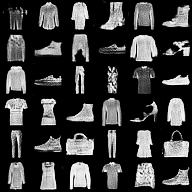

In [12]:
from IPython.display import Image
Image(filename='figs/fig.png')

### Task 3 (5 points)
Evaluate discrimator accuracy in the pre-trained model on any representative subsample of fashion-minst

In [13]:
import random

sample_directory = './figs' #Directory to save sample images from generator in.
model_directory = './models' #Directory to load trained model from.
samples_count = 10000

path = model_directory + '/model-20000.cptk'

init = tf.global_variables_initializer()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    #Reload the model.
    print( 'Loading Model...')
    
    saver.restore(sess, save_path=path)
    acc = 0

    mnist_batch, _ = mnist.test.next_batch(samples_count)
    mnist_batch = (np.reshape(mnist_batch,[samples_count,28,28,1]) - 0.5) * 2.0 #Transform it to be between -1 and 1
    mnist_batch = np.lib.pad(mnist_batch, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1))
    res = sess.run(Dx, feed_dict={real_in: mnist_batch})
    acc += (res >= 0.5).sum()

    z2 = np.random.uniform(-1.0,1.0,size=[samples_count, z_size]).astype(np.float32) #Generate a random z batch
    gen_batch = sess.run(Gz,feed_dict={z_in:z2})
    res = sess.run(Dx, feed_dict={real_in: gen_batch})

    acc += (res < 0.5).sum()
    
    acc /= (2*samples_count)
    print('Accuracy on {} samples: {}'.format(samples_count, acc))

Loading Model...
INFO:tensorflow:Restoring parameters from ./models/model-20000.cptk
Accuracy on 10000 samples: 0.5578
